### <font color = 'purple'> Hongchi Zhang

# MTH9875 Homework 9

Assigned: October 27, 2016.
Due: November 10, 2016 by 6pm.

Late homework **will not be accepted**.

<font color = "red">Homework is to be done by each student individually.  To receive full credit, you must email a completed copy of this iPython notebook to Victor Istratov (stavka@gmail.com), Yassine Ghalem (yassine.ghalem@gmail.com) and Jim Gatheral (jim.gatheral@gmail.com) by the due date and time.  All R-code must run correctly and solutions must be written up neatly in Markdown/LaTeX format.

### As usual, download some code

The following code sources *BlackScholes.R* which has the Black-Scholes formula and implied volatility computation and *Heston2.R* which has in particular the *impvolHeston* function.

In [55]:
download.file(url="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/09/BlackScholes.R.zip", destfile="BlackScholes.R.zip")
unzip(zipfile="BlackScholes.R.zip")
source("BlackScholes.R")
source("Heston2.R")

## A special case of Heston: The Heston-Nandi model
$$
\newcommand{\supp}{\mathrm{supp}}
\newcommand{\E}{\mathbb{E} }
\def\Cov{{ \mbox{Cov} }}
\def\Var{{ \mbox{Var} }}
\newcommand{\1}{\mathbf{1} }
\newcommand{\PP}{\mathbb{P} }
%\newcommand{\Pr}{\mathrm{Pr} }
\newcommand{\QQ}{\mathbb{Q} }
\newcommand{\RR}{\mathbb{R} }
\newcommand{\DD}{\mathbb{D} }
\newcommand{\HH}{\mathbb{H} }
\newcommand{\spn}{\mathrm{span} }
\newcommand{\cov}{\mathrm{cov} }
\newcommand{\sgn}{\mathrm{sgn} }
\newcommand{\HS}{\mathcal{L}_{\mathrm{HS}} }
%\newcommand{\HS}{\mathrm{HS} }
\newcommand{\trace}{\mathrm{trace} }
\newcommand{\LL}{\mathcal{L} }
%\newcommand{\LL}{\mathrm{L} }
\newcommand{\s}{\mathcal{S} }
\newcommand{\ee}{\mathcal{E} }
\newcommand{\ff}{\mathcal{F} }
\newcommand{\hh}{\mathcal{H} }
\newcommand{\bb}{\mathcal{B} }
\newcommand{\dd}{\mathcal{D} }
\newcommand{\g}{\mathcal{G} }
\newcommand{\p}{\partial}
\newcommand{\half}{\frac{1}{2} }
\newcommand{\T}{\mathcal{T} }
\newcommand{\bi}{\begin{itemize}}
\newcommand{\ei}{\end{itemize}}
\newcommand{\beq}{\begin{equation}}
\newcommand{\eeq}{\end{equation}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\cO}{\mathcal{O}}
\newcommand{\cF}{\mathcal{F}}
\newcommand{\cL}{\mathcal{L}}
$$

If we believe the argument of Lecture 4 preceding formula (21), if $\rho=\pm1$, Heston local variance should be well approximated by (*e.g.* (4.1) on page 44 of The Volatility Surface):

<a name="eq:Hestonlv"></a>(1)
$$
\beas
 v_L(x_T,T) &=& \left[\hat v'_{ T} \,-\, \eta
 \,\frac{{x_T }}{{w_T }}\,\int_0^T {\hat v_s } \,e^{
 - \lambda '(T - s)} ds \right]^+\nonumber\\
 &=&\left[(v-\bar v') e^{ - \lambda' T} +\bar v' \,-\,\eta \, x_T
 \,\left\{ \frac{1-e^{-\lambda' T}}{\lambda' T } \right\}\right]^+
\eeas
$$

with $ \lambda ' = \lambda  +\frac { \eta}{2}$, $\bar v' = \bar v
\frac {\lambda }  {\lambda '}$.  The whole expression must be
bounded below by zero - all stock prices above the critical stock
price at which the local variance reaches zero are unattainable.







Following Chapter 4 of The
Volatility Surface, we will show this numerically by simulation.  For each of the problems below, take $T=1$ year as the time horizon with Heston parameters:
\begin{eqnarray*}
v&=& 0.04\\ \bar v &=& 0.04\\ \lambda&=&10\\ \eta&=&1\\\rho&=&-1.
\end{eqnarray*}



### 1. (16 points)

(a)

Use your Monte Carlo code (not QMC!) from HW6 Problem 4 to return vectors of $x=\log S_T/S_0$ and instantaneous variance $v$ with the above Heston-Nandi parameters.  Run the code with $N=2,000,000$ paths, $m=64$ (128 steps), and *evolve=evolveAlfonsiF* .  (Tip: Save the results so you can reuse these samples of $x$ and $v$ and avoid lengthy reruns of the MC code.)

In [56]:
#Heston-Nandi Parameters
library(randtoolbox)
paramsHN <- list(lambda = 10,rho = -1.0,eta = 1,vbar = 0.04,v = 0.04)
N = 2000000
m = 64

In [57]:
generateMCpath <-function(params){
    
    is.even <- function(j){as.logical((j+1) %% 2)}
    
    res <- function(S0, T, AK, N, m, evolve,exactVols=NULL)
    {
  
    lambda <<- params$lambda;
    rho <<- params$rho;
    eta <<- params$eta;
    vbar <<- params$vbar;
    v0 <<- params$v;
  
    n <- m*2; #n is number of timesteps = 2*m so we can use Romberg extrapolation
    sqrt2 <- sqrt(2);
    rho2m1 <<- sqrt(1-rho*rho);
    vbarp <<- vbar - eta^2/(4*lambda);
    
    negCount <- 0;
    
    # We use a vertical array, one element per M.C. path
    x <- rep(0,N); v <- rep(1,N)*v0;
    xm <- x; vm <- v;
    W1m <- rep(0,N); W2m <- rep(0,N); 
  
    # Loop for bias computation (N small, n big)
    for (i in 1:n)
    {
        # Two sets of correlated normal random vars.
        
        W1 <- rnorm(N);
        W2 <- rnorm(N);
        W1 <- W1 - mean(W1); W1 <- W1/sd(W1);
        W2 <- W2 - mean(W2); W2 <- W2/sd(W2);
        # Now W1 and W2 are forced to have mean=0 and sd=1
        
        W2p <- W2 - cor(W1,W2)*W1; # Eliminate actual correlation
        W2p <- W2p - mean(W2p); W2 <- W2p/sd(W2p); 
        # Now W1 and W2 have mean=0, sd=1 and correlation=0
        
        L <- rbinom(N, size=1, prob=1/2); # Bernoulli rv for NV step
    
        # Add code for subgrid
        W1m <- W1m + W1/sqrt2; W2m <- W2m + W2/sqrt2; # N(0,1) rv's for subgrid
       
        if (is.even(i)) {
            #print(c(i,mean(W1m),mean(W2m),sd(W1m),sd(W2m),cor(W1m,W2m)));
            resm <- evolve(vm,xm,T/m,W1m,W2m,L);
            xm <- resm[,1];
            vm <- resm[,2];
            W1m <- rep(0,N); W2m <- rep(0,N);
        }
    
        res <- evolve(v,x,T/n,W1,W2,L);
        x <- res[,1];
        v <- res[,2];
        negCount <- negCount +mean(v<0)/n; #Probability of negative variance per path per timestep  
   }     
        result = list("x" = x, "v" = v)
        return(result) 
  }
        return (res)
}

In [58]:
#Define the evolveAlfonsiF function to generate MC paths
evolveAlfonsiF <- function(v,x,dt,W1,W2,L=NULL){

        eldt2 <- exp(-lambda*dt/2);

        #Variance process
        vbarp <- vbar - eta^2/(4*lambda);
        psi <- (1-eldt2)/lambda;
        v1 <- v*eldt2 + lambda*vbarp*psi;
        v2 <- (v1 > 0) * v1; # Take v2 = 0 if v1<0, else v2=v1
        par <- sqrt(v2) + eta/2*sqrt(dt)*W2;
        vf <- eldt2*par*par + lambda*vbarp*psi;

        # Log-stock process (Andersen equation (33))
        vvf <- (v+vf > 0) * (v+vf);
        dw <- vvf/2*dt;
        x <- x  - dw/2 + rho2m1*sqrt(dw)*W1 +
            rho/eta*(lambda*dw + vf-v -lambda*vbar*dt) ;
        # Impose martingale constraint
        x <- x - log(mean(exp(x)));
        v <- vf;
        return(cbind(x,v));
}

#Define Heston MC function
HestonMC2 <- function(S0,AK,x,m){

    N = length(x)
    S <- S0*exp(x);
    M <- length(AK);
    AV <- numeric(M); AVdev <- numeric(M);
    BSV <- numeric(M); BSVH <- numeric(M); BSVL <- numeric(M);
    iv2SD <- numeric(M); bias <- numeric(M);
  
  # Evaluate mean call value for each path
  for (i in 1:M)
  {
    # 2*m timesteps
    K <- AK[i];
    V <- (S>K)*(S - K); # Boundary condition for European call
    AV[i] <- mean(V);
    AVdev[i] <- sqrt(var(V)/length(V));  
    BSV[i] <- BSImpliedVolCall(S0, K, T=1, 0, AV[i]);
    BSVL[i] <- BSImpliedVolCall(S0, K, T=1, 0, AV[i] - AVdev[i]);
    BSVH[i] <- BSImpliedVolCall(S0, K, T=1, 0, AV[i] + AVdev[i]);
    iv2SD[i] <- (BSVH[i]-BSVL[i]);
    
  }
  
  l.AK <- length(AK)      
  data.out <- data.frame(AK,rep(N,l.AK),rep(2*m,l.AK),BSV) 
  names(data.out) <- c("Strikes","Paths","Steps","ivol") 
#-----------------------------------------------------------------------------------------------------------------------------------------------------  
#Amendment
  result = list("output"=data.out)
  return(result) 
#------------------------------------------------------------------------------------------------------------------------------------------------------  
}

In [59]:
sample_xv <- generateMCpath(paramsHN)(S0=1, T=1, AK=1, N=N, m=m, evolve=evolveAlfonsiF) 

In [60]:
#Save x and v
x_sample = sample_xv$x
v_sample = sample_xv$v

(b)

Plot the Heston-Nandi 1-year implied variance smile for log-strikes between $-1.0$ and $1.0$.  Superimpose the implied volatility smile from the Heston quasi-closed form formula.  As usual, nice formatting please!

In [63]:
ks = seq(-1.0,1.0,0.02)
#ks = seq(0.6,1.5,0.1)
MCvar = function(k){(HestonMC2(1,exp(k),x_sample,m)$output['ivol'][1,])^2}
MCvol = function(k){(HestonMC2(1,exp(k),x_sample,m)$output['ivol'][1,])}
MCvol_vec = sapply(ks,MCvol)
Hvol = function(k){impvolHeston(paramsHN)(k,t=1)}
Hvol_vec = sapply(ks,Hvol)


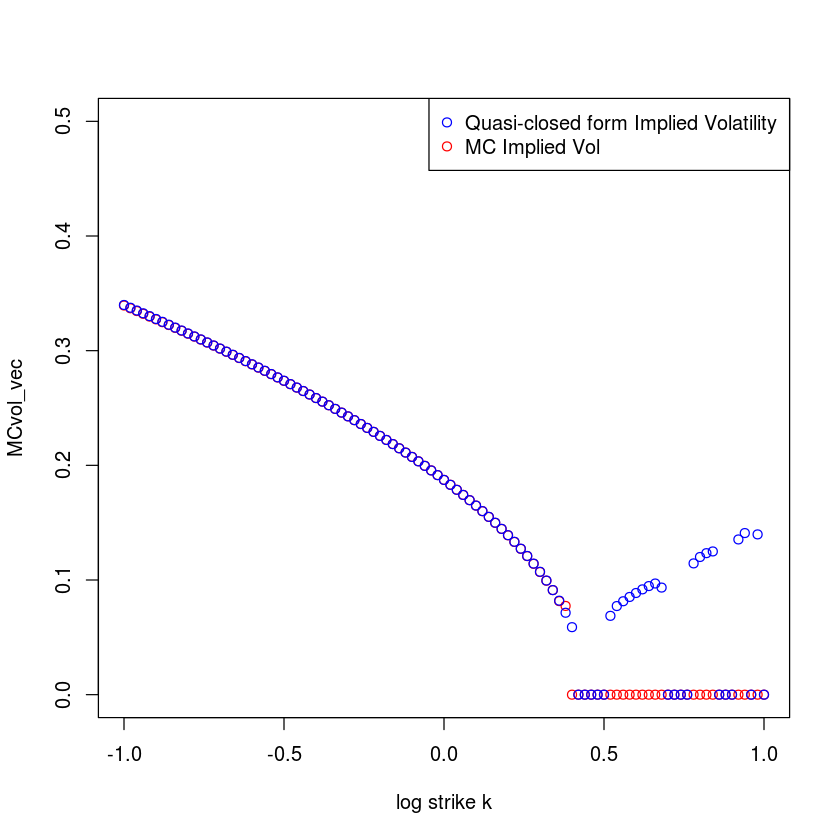

In [64]:
plot(ks,MCvol_vec,col = 'red',type='p',lty=2,xlab="log strike k",ylim =c(0,0.5))
points(ks,Hvol_vec,col='blue')
legend('topright',c('Quasi-closed form Implied Volatility','MC Implied Vol'),col=c('blue','red'),pch=c(1,1))

(c)

Consider the surface SVI (SSVI) parameterization

<a name="eq:ssvi"></a>(2)
$$
w(k,\theta_t)
= \frac{\theta_t}{2}\left\{1+\rho\varphi(\theta_t) k + \sqrt{\left(\varphi(\theta_t){k}+\rho\right)^2
+(1-\rho^2 )}\right\}.
$$

Set $t=1$.  Show that the ATM implied variance $\sigma_{\text{BS}}^2(0,1) = \theta$, and that the ATM variance skew $\p_k \sigma_{\text{BS}}^2(k,1)|_{k=0}= \rho\,\theta\,\varphi$.

<font color = 'blue'>

ATM Implied Variance is given by

\begin{eqnarray}
\sigma_{\text{BS}}^2(0,1) &=& w(0,\theta_1) \\
&=& \frac{\theta_1}{2}\,(1 + 1) \\
&=& \theta
\end{eqnarray}

<font color = 'blue'>

\begin{eqnarray}
\p_k \sigma_{\text{BS}}^2(k,1) &=& \frac{\theta_1}{2}(\rho\varphi + \frac{2(\varphi\,k+\rho)\varphi}{2\,\sqrt{(\varphi\,k + \rho)^2 + (1-\rho^2)}})
\end{eqnarray}

<font color = 'blue'>

Therefore, ATM Variance Skew is given by

\begin{eqnarray}
\p_k \sigma_{\text{BS}}^2(k,1)|_{k=0} &=& \frac{\theta_1}{2}(\rho\varphi + \rho\varphi)\\
&=& \rho\,\theta\,\varphi
\end{eqnarray}

(d)

Simplify the SSVI formula [(2)](#eq:ssvi) in the special case where $\rho=-1$. 

<font color = 'blue'>

Plug in $\rho = -1$ into formula (2), we get

$$
w(k,\theta_t) = \frac{\theta_t}{2}\left\{1 - \varphi\,k + |1 - \varphi\,k|\right\}
$$

(e)

Estimate the Monte Carlo ATM implied variance level and skew.  Assuming $\rho=-1$, deduce $\theta$ and $\varphi$.  Display the resulting SSVI fit on the plot obtained in part (b).  

$$
w(k,\theta_t)
= \frac{\theta_t}{2}\left\{1+\rho\varphi(\theta_t) k + \sqrt{\left(\varphi(\theta_t){k}+\rho\right)^2
+(1-\rho^2 )}\right\}.
$$

In [65]:
dk = 0.001
MC_skew = (MCvar(dk) - MCvar(-dk))/2/dk
MC_ATM = MCvar(0)
theta = MC_ATM
phi = MC_skew/(-1)/(theta)
print(paste('phi :',phi))
print(paste('theta :',theta))

[1] "phi : 2.24779030146722"
[1] "theta : 0.0350899082432719"


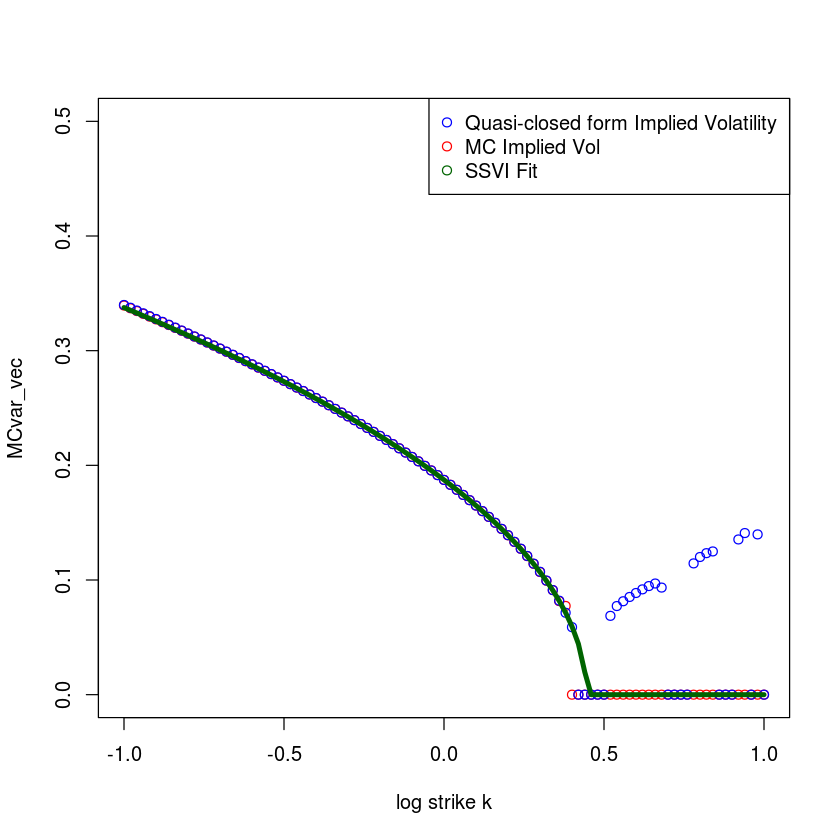

In [66]:
SSVI = function(k){
    res = theta/2.0*(1-phi*k + abs(1-phi*k))
    res = sqrt(res)
    return (res)
}

ks = seq(-1.0,1.0,0.02)
SSVI_vol_vec = sapply(ks,SSVI)
plot(ks,MCvar_vec,col = 'red',type='p',lty=2,xlab="log strike k",ylim =c(0,0.5))
points(ks,Hvol_vec,col='blue')
lines(ks,SSVI_vol_vec,col='dark green',lwd=4)
legend('topright',c('Quasi-closed form Implied Volatility','MC Implied Vol','SSVI Fit'),col=c('blue','red','dark green'),pch=c(1,1,1))



### Numerical check of local volatility formula

### 2. (6 points) 

Using  the $x$ and $v$ samples you generated in Problem 1, numerically estimate the local volatility function

[(3)](#eq:lvNumerical)
$$
v_L(x,1)=\E[v_1|x_1=x]
$$

Plot local variance $v_L(x,1)$ as a function of $x$ from $x=-0.5$ to $x=+0.5$.  As in HW4, I recommend just binning the data.  Superimpose a graph of formula [(1)](#eq:Hestonlv).  Verify agreement of [(1)](#eq:Hestonlv) and [(3)](#eq:lvNumerical).

<font color = 'blue'>
<a name="eq:Hestonlv"></a>(1)
$$
\beas
 v_L(x_T,T) &=& \left[\hat v'_{ T} \,-\, \eta
 \,\frac{{x_T }}{{w_T }}\,\int_0^T {\hat v_s } \,e^{
 - \lambda '(T - s)} ds \right]^+\nonumber\\
 &=&\left[(v-\bar v') e^{ - \lambda' T} +\bar v' \,-\,\eta \, x_T
 \,\left\{ \frac{1-e^{-\lambda' T}}{\lambda' T } \right\}\right]^+
\eeas
$$

with $ \lambda ' = \lambda  +\frac { \eta}{2}$, $\bar v' = \bar v
\frac {\lambda }  {\lambda '}$. 

In [67]:
# Local Variance Approximation formula
lv_approx = function(params){
    
    res <- function(x,t){
        lambda <<- params$lambda;
        rho <<- params$rho;
        eta <<- params$eta;
        vbar <<- params$vbar;
        v0 <<- params$v;
        
        lambda_p = lambda + eta/2.0
        v_barp = vbar * lambda / lambda_p
        
        tmp1 = (v0-v_barp)*exp(-lambda_p*t) + v_barp
        tmp2 =  -eta * x * (1-exp(-lambda_p * t))/(lambda_p*t)
        
        result = tmp1 + tmp2 
        result = result * (result > 0)
        return (result)
    }
    return (res)
}


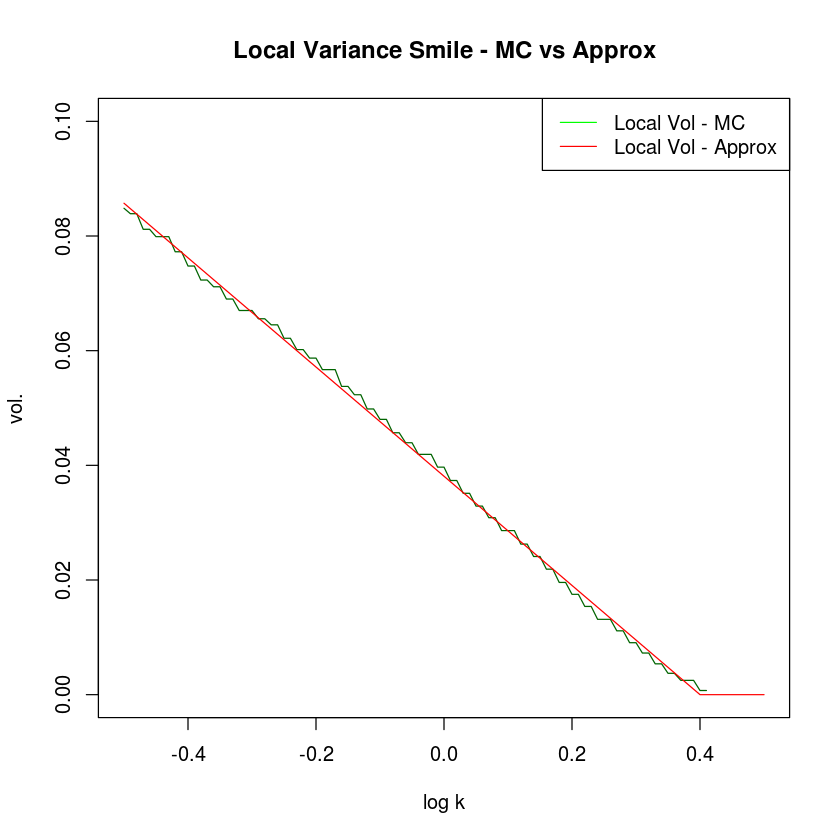

In [69]:
local_var = function(x,x_arr,v_arr){
    max_x = max(x_arr)
    min_x = min(x_arr)
    bin = 150
    tol = (max_x - min_x)/bin
    i = floor((x - min_x)/tol)
    low = min_x + i*tol
    high = min_x + (i+1)*tol
    indicator = (x_arr > low) * (x_arr < high)
    N = sum(indicator)
    #print(N)
    res = sum(v_arr*indicator)/N
    return (res)
}

ks = seq(-0.5,0.5,0.01)
lv = function(k){lv_approx(paramsHN)(k,1)}
lv_approx_vec = sapply(ks,lv)
lv_MC = sapply(ks,function(k){local_var(k,x_sample,v_sample)})
plot(ks,lv_MC,col='dark green',type='l',xlab="log k",ylab="vol.",main = "Local Variance Smile - MC vs Approx",
    ylim=c(0,0.1))
lines(ks,lv_approx_vec,col = 'red')
legend('topright',c('Local Vol - MC','Local Vol - Approx'),col= c('green','red'),lty=1)

## Local volatility simulation

### 3. (10 points) 

Amend the Monte Carlo code of Problem 1 to generate a vector of $x=\log S_T/S_0$ assuming the local volatility process:

$$
dx=-\frac{1}{2}\,v_L(x,t)\,dt+\sqrt{v_L(x,t)}\,dZ
$$

with the approximate formula [(1)](#eq:Hestonlv) for local variance.  Again, with 2 million paths and 128 steps, plot the 1-year volatility smile for log-strikes between $-1.0$ and $1.0$.  Superimpose this smile on the Heston implied volatility smiles generated in Problem 1.  

In [70]:
#Underlying evolvement under local volatility model
evolveLV <- function(t,x,dt,W1){

        #Local Variance function
        vl_x_t = lv_approx(paramsHN)(x,t)

        x <- x  - vl_x_t * dt /2.0 + sqrt(vl_x_t * dt )*W1
        # Impose martingale constraint
        x <- x - log(mean(exp(x)));
        return(x);
}

In [71]:
#Generate vectors of stock price in local volatility model
generateMCpath_LV <-function(S0, T, N, m, evolve)
{

    m = m*2
    # We use a vertical array, one element per M.C. path
    x <- rep(0,N); 


    # Loop for bias computation (N small, n big)
    for (i in 1:m)
    {
        t = i * T / m
        W1 <- rnorm(N);
        W1 <- W1 - mean(W1); W1 <- W1/sd(W1);        
        res <- evolve(t,x,T/m,W1);
        x <- res;
    }     
    return (x)
}


In [72]:
x_lv = generateMCpath_LV(S0=1,T=1,N=N,m=m,evolve = evolveLV)

In [75]:
MCLV_vol = function(k){(HestonMC2(1,exp(k),x_lv,m)$output['ivol'][1,])}
MCLV_vol_vec = sapply(ks,MCLV_vol)

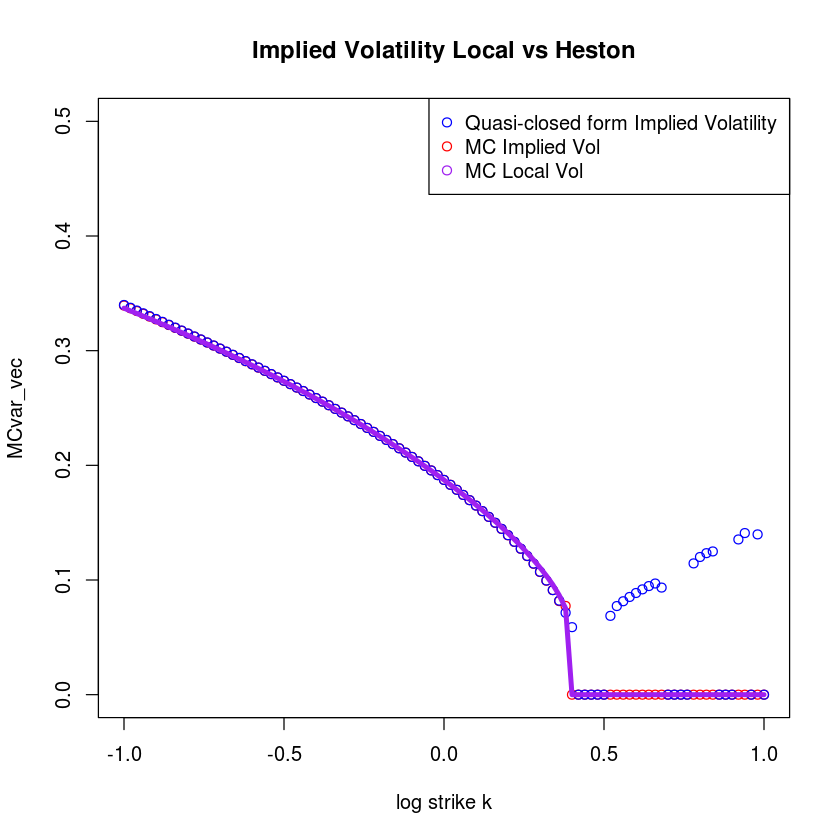

In [76]:
ks = seq(-1.0,1.0,0.02)
SSVI_vol_vec = sapply(ks,SSVI)
plot(ks,MCvar_vec,col = 'red',type='p',main = "Implied Volatility Local vs Heston", lty=2,xlab="log strike k",ylim =c(0,0.5))
points(ks,Hvol_vec,col='blue')
lines(ks,MCLV_vol_vec,col='purple',lwd=4)
legend('topright',c('Quasi-closed form Implied Volatility','MC Implied Vol','MC Local Vol')
       ,col=c('blue','red','purple'),pch=c(1,1,1))

## Intuition

### 4. (4 points) 


From the results of your computations, you should see that the local
volatility model and the stochastic volatility model price one year
European options almost identically.  Also, because  $\rho=-1$, both the Heston model of Problem 1 and the local volatility model of Problem 2 are only one-factor, depending only on stock prices. Are there any
differences between the two models? If so, what are these differences?

<font color = 'blue'>

1. Time homogeneity - The key difference is that local volatility model is NOT homogeneous in time whereas stochastic volatility model is homogeneous in time. That's why local volatility will generate a forward skew that is rather flat but stochastic volatility model will say that the forward skew is almost the same as today

2. Many exotic options pricing depend on the projection of forward skew. Although stochastic vol and local vol price one year European option almost identically but they can price exotics very differently

3. Local volatility assumes volatility in the future is known today(dependent on only time and stock price). This assumption is rather unrealistic. Stochastic volatility assumes more realistic dynamics, volatility is stochastic


## Postscript

You now have working Heston-Nandi stochastic volatility and local volatility codes.  We will use these later to check our intuition for the impact of dynamical assumptions on the pricing of exotic options.